In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import cosmoplots
import scipy.signal as ssi

from scipy.optimize import minimize

from fppanalysis.running_moments import window_radius, run_norm_ds
from fppanalysis.correlation_function import corr_fun

from analysis_functions.constants import greenwald_fraction, shot_time_window
from analysis_functions.functions import psd_eq, error_func_psd, find_closest_value
from analysis_functions.apd_functions import get_signal, get_time, get_rz, get_dt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### This code plots power spectrum density and computes its fit to Lorentzian spectra

In [2]:
shotlist = [1110201016, 1110201011, 1160616018]
f_GWs = [greenwald_fraction[shot] for shot in shotlist]
marker_list = ['^', 'o', 'v']
color_list = ['#785EF0', '#DC267F', '#FFB000']
label_name = ['EDA H', 'ELM-free H', 'Ohmic']

$\overline{\tau_d}$ = 17.3$\mu s$ $\overline{\lambda} = $0.11


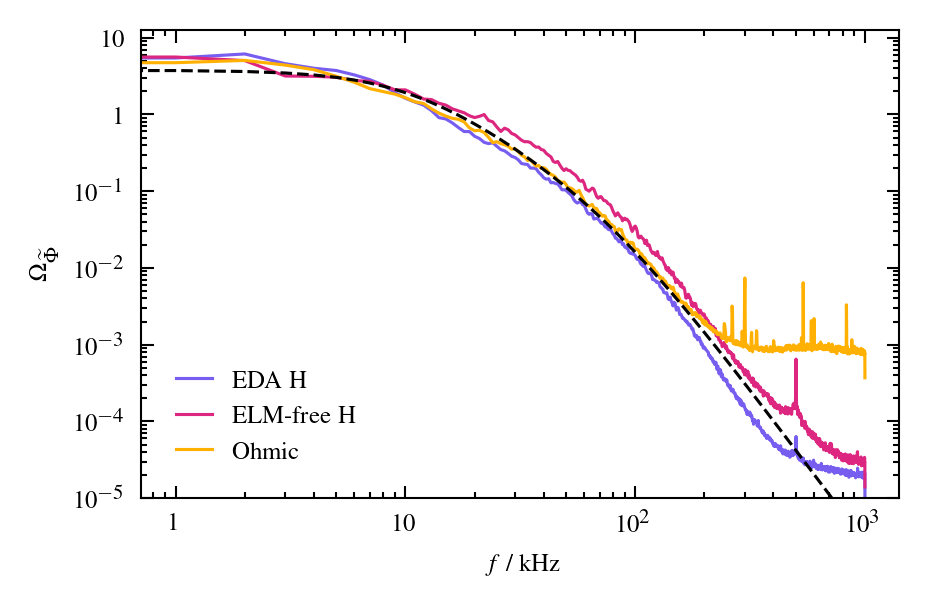

In [11]:
save = False

axes_size = cosmoplots.set_rcparams_dynamo(plt.rcParams, num_cols=1, ls="thin")
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["font.size"] = 6
plt.rcParams["legend.fontsize"] = 6
plt.rcParams["axes.labelsize"] = 6
plt.rcParams["xtick.labelsize"] = 6
plt.rcParams["ytick.labelsize"] = 6
plt.rcParams["xtick.major.size"] = 3
plt.rcParams["xtick.minor.size"] = 1.5
plt.rcParams["ytick.major.size"] = 3
plt.rcParams["ytick.minor.size"] = 1.5
plt.rcParams["ytick.minor.width"] = 0.5
plt.rcParams["xtick.minor.width"] = 0.5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["xtick.major.width"] = 0.5

fig = plt.figure()
ax = fig.add_axes(axes_size)

x_pixel = 7
y_pixel = 4

average_td_psd = []
average_lam_psd = []

for idx, shot in enumerate(shotlist):

    f_GW = greenwald_fraction[shot]
    path = Path("/Users/ahe104/Box/mfe_data/raw_apd_data/")
    ds = xr.open_dataset(str(path) + "/" + f"apd_signal_array_{shot}.nc")

    # Remove dead pixels
    path_dead_pixel = Path('/Users/ahe104/Box/mfe_data/dead_pixels')
    dead_pix = np.load(
        str(path_dead_pixel)
        + "/"
        + f"dead_pixels_shot_{shot}.npz"
    )
    dead_pix_arr = dead_pix['dead_pix_arr'] # Don't flip array, quiver plot is oriented this way
    dead_pix_arr_ds = dead_pix_arr[::-1,:] # Flip array to match ds['frames'] orientation
    for y in range(dead_pix_arr_ds.shape[0]):
        for x in range(dead_pix_arr_ds.shape[1]):
            if dead_pix_arr_ds[9-y, x]:
                ds['frames'].loc[dict(y=y, x=x)] = np.nan

    t_start = shot_time_window[shot][0]
    t_end = shot_time_window[shot][1]
    sliced_ds = ds.sel(time=slice(t_start, t_end))
    radius = window_radius(1e3, sliced_ds.time)
    ds = run_norm_ds(sliced_ds, radius)

    time = get_time(x=x_pixel, y=y_pixel, ds=ds)
    data = get_signal(x=x_pixel, y=y_pixel, ds=ds)

    # Find length of time window for running normalization
    freq = 1e3
    window = window_radius(freq, time)

    # PSD
    dt = get_dt(ds)
    fs = 1 / dt
    nperseg = window * 2
    f_welch, power_welch = ssi.welch(data, fs, nperseg=nperseg)

    # Auto correlation function
    correlated = corr_fun(data, data, dt)
    fit_exp_start = np.where(correlated[0] == 0)[0][0]
    fit_exp_end = np.where(correlated[0] == find_closest_value(correlated[0], 0.0002))[0][0]

    acorr_signal_x = correlated[0][fit_exp_start:fit_exp_end] * 1e6
    acorr_signal_y = correlated[1][fit_exp_start:fit_exp_end]

    # Specify fit
    section_start = 1e3
    section_end = 2e5
    f_fit = f_welch[(f_welch > section_start) * (f_welch < section_end)]
    power_fit = power_welch[(f_welch > section_start) * (f_welch < section_end)]

    # Minimize
    res_psd = minimize(
        lambda params: error_func_psd(params, f_fit, power_fit),
        method="Nelder-Mead",
        x0=[22e-6, 0.1],
    )

    R, Z = get_rz(x_pixel, y_pixel, ds)

    # ------------------- Plot ------------------- #
    ax.plot(f_welch/1e3, power_welch/power_welch[0], color_list[idx], label=label_name[idx])

    average_td_psd.append(res_psd.x[0])
    average_lam_psd.append(res_psd.x[1])

R, Z = get_rz(x_pixel, y_pixel, ds)
R_round = '{:.2f}'.format(R)
Z_round = '{:.2f}'.format(Z)

# Plot average fit
ax.plot(
    f_welch/1e3,
    psd_eq(f_welch, np.mean(average_td_psd),np.mean(average_lam_psd))/power_welch[0],
    color='black',
    linestyle="--",
)

print(
    r"$\overline{\tau_d}$ = " 
    f"{np.round(np.mean(average_td_psd)*1e6,1)}"
    r"$\mu s$"
    r" $\overline{\lambda} = $"
    f"{np.round(np.mean(average_lam_psd),2)}"
)

ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel(r"$f$ / kHz")
ax.set_ylabel(r"$\Omega_{\widetilde{\Phi}}$")
ax.set_ylim(bottom=1e-5)
# Base tick labels
cosmoplots.change_log_axis_base(ax, "x")
cosmoplots.change_log_axis_base(ax, "y")
ax.legend(frameon=False, borderaxespad=1, loc='lower left')

if save == True:
    format = "pdf"
    foldername = '/Users/ahe104/Box/time_delay_estimation/velocity_field/analysis/PSI/'
    filename = f'apd_psd_multiple_shots_x_{x_pixel}_y_{y_pixel}.{format}'
    fig.savefig(foldername + filename, bbox_inches="tight", format=format)